# Calibration of the preprocessing algorithm
IFT Preprocessing includes the following steps and tunable parameters.

| Step | Function | Parameters | Notes |
| --- | --- | --- | --- |
| 1 | Anisotropic Diffusion | Iterations, Kappa, Lambda| Perona and Malik (1990) algorithm |
| 2 | Tiled Adaptive Histogram | Tile size | |
|   |                          | Entropy threshold |  May depend on tile size|
|   |                          | White fraction thresholds | May depend on tile size|
| 3 | Reconstruct | Structuring element | Reconstruction with the hist-adj image |
| 4 | Sharpen | Radius | |
|   |         | Amount | |
| 5 | Reconstruct | Structuring element | Reconstruction with the sharpened image |
| 6 | Brighten Ice | Brighten Factor | Constrast adjustment using the green channel |
| 7 | Compute Residue | | Subtract the reconstructed image from the brightened image |
| 8 | Gamma Correction |  gamma | Uses the Images.adjust_histogram function with GammaCorrection algorithm |
|   |                  | gamma\_factor | |
|   |                  | gamma\_threshold | |


## Methods for calibration
We can vary the tile size, the thresholds for applying the adaptive histogram equalization, the sharpening settings, the choice of structuring elements, and the brightening factor. That's a total of 9 parameters. I also have to look at whether there are simplifications that I can apply.

## Code updates
1. Done: Refactored the Perona-Malik algorithm so that we can use the exponential or the inverse quadratic version of the flux function.
2. To do: 
    - How many iterations are needed? 
    - What value should the Kappa and Lambda coefficients have?
    - Is there a noticeable difference between the inverse quadratic and exponential methods?
    - Can we include an example of diffusion in action on the website?
3. Updating the tiled operation to allow filtering the tiles. Since we operate on a list, we can just process the tiles that are likely to contain ice, and skip images without potential ice.
    - `filter( )` works, and we can add a function that does this first pass.
    - I'd like to set thresholds for cloud fraction (from the cloudmask) and band 2 contrast within tiles.
5. Update reconstruction to use the ImageMorphology functions directly, and be clear about the goal of each.
   - Grayscale morphological reconstruction selects level sets greater than some minimum depth, analogous to the way that standard reconstruction can find regions that intersect with a set of markers.
   - Dilation is only optimized for diamond and box structuring elements.
7. Update the unsharp_mask function, making sure that it works on all image types the way it should.

## Tiling iteration updates
- Goal: find set of parameters that help us identify the tiles to include.
  - Cloud fraction, fraction of possible sea ice, contrast

In [1]:
using Pkg
Pkg.activate("../scripts/cal-val")
using Images
using IceFloeTracker
using CairoMakie
using StatsBase
using CSV

Pkg.resolve()

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val`
  No Changes to `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val/Project.toml`
  No Changes to `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val/Manifest.toml`


In [15]:
# the dev folder includes some functionality in IFT that isn't yet in the registry version
include("../scripts/dev/validation_data.jl")
include("../scripts/dev/gradient_functions.jl")
include("../scripts/dev/nonlinear_diffusion.jl")

anisotropic_diffusion_2D (generic function with 1 method)

# Things to add to this notebook
## Comparison to prior version
1. Function that applies the Tiling 2019 algorithm to an image
2. Large example image that I use to test a range of tile sizes
3. Function to visualize which tiles are selected by the preprocessing algorithm

## Checking potential adjustments
1. Does it matter that we reconstruct twice?
2. What steps can we turn off and on?

## Test and calibrate with the 100 km images

In [ ]:
# Large image for testing
# # dates: 20200530, 20030623
# examp_subset = (100:1100, 500:2500)
# tc_img = load("../../data/modis_data/20200530.250m.aqua/truecolor.tiff")[examp_subset...]
# fc_img = load("../../data/modis_data/20200530.250m.aqua/falsecolor.tiff")[examp_subset...]
# lm_img = load("../../data/modis_data/20200530.250m.aqua/landmask.binarized.tiff")[examp_subset...]
# nothing

In [ ]:
function unsharp_mask(
    img::AbstractArray{<:Union{AbstractRGB,TransparentRGB,AbstractGray}},
    radius::Real=3,
    amount::Real=0.5,
    threshold::Real=0.01)

    image_float = float64.(img)
    image_smoothed = imfilter(image_float, Kernel.gaussian(radius))

    cv_image = channelview(image_float)
    cv_smooth = channelview(image_smoothed)    
    diff = cv_image .- cv_smooth
    cv_sharp = cv_image .+ diff .* amount
    clamp!(cv_sharp, 0, 1)

    # # Convert back into an image of the original type
    sharpened_image = colorview(base_colorant_type(eltype(img)), cv_sharp)
    sharpened_image = convert.(eltype(img), sharpened_image)

    # Optionally use only where sharpening is larger than threshold
    diff_magnitude = length(size(diff)) > 2 ? dropdims(sqrt.(sum(diff.^2, dims=1)); dims=1) : abs.(diff)

    threshold > 0 && (sharpened_image[diff_magnitude .< threshold] .= img[diff_magnitude .< threshold])
    
    return sharpened_image
end

In [3]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c-> c.case_number == 4 && c.satellite == "terra")

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


ValidationDataSet(Base.Generator{DataFrames.DataFrameRows{DataFrame}, var"#5#8"{Watkins2025GitHub}}(var"#5#8"{Watkins2025GitHub}(Watkins2025GitHub("a451cd5e62a10309a9640fbbe6b32a236fcebc70", "https://github.com/danielmwatkins/ice_floe_validation_dataset/", "data/validation_dataset/validation_dataset.csv", "/tmp/Watkins2025")), 1×28 DataFrameRows
 Row │ case_number  region      start_date  center_lon  center_lat  center_x   ⋯
     │ Int64        String      Date        Float64     Float64     Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           4  baffin_bay  2019-09-25    -76.8094     79.3029   -612500   ⋯
                                                              22 columns omitted), 1×28 DataFrame
 Row │ case_number  region      start_date  center_lon  center_lat  center_x   ⋯
     │ Int64        String      Date        Float64     Float64     Int64      ⋯
─────┼──────────────────────────────────────────────────────────────

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


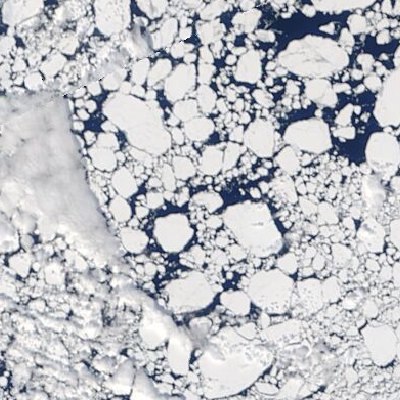

In [4]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c-> c.case_number == 6 && c.satellite == "terra")
case = first(dataset);
tc_img = deepcopy(case.modis_truecolor)

In [ ]:
print("Red: ", 0.1 * (percentile(vec((red.(tc_img))), 99) - percentile(vec((red.(tc_img))), 1)), "\n")
print("Green: ", 0.1 * (percentile(vec((green.(tc_img))), 99) - percentile(vec((green.(tc_img))), 1)), "\n")
print("Blue: ", 0.1 * (percentile(vec((blue.(tc_img))), 99) - percentile(vec((blue.(tc_img))), 1)), "\n")

In [ ]:
print("Gray: ", 0.1 * Float64.(percentile(vec((Gray.(tc_img))), 99) - percentile(vec((Gray.(tc_img))), 1)), "\n")

In [ ]:

diffused_matlab = anisotropic_diffusion_2D(green.(tc_img); niter=5)
gradient_threshold = 0.1 * (percentile(vec((green.(tc_img))), 99) - percentile(vec((green.(tc_img))), 1))
print("Gradient threshold:", gradient_threshold)

pmd = PeronaMalikDiffusion(0.1, gradient_threshold, 10, "inverse_quadratic");
diffused_julia = nonlinear_diffusion(Gray.(green.(tc_img)), pmd);

In [ ]:
Images.mosaicview(Gray.(green.(tc_img)), diffused_matlab, diffused_julia, nrow=1)

In [ ]:

pmd = PeronaMalikDiffusion(0.1, gradient_threshold, 10, "inverse_quadratic");
iq_diffused_julia = nonlinear_diffusion(Gray.(green.(tc_img)), pmd);

pmd = PeronaMalikDiffusion(0.1, gradient_threshold, 10, "exponential");
ex_diffused_julia = nonlinear_diffusion(Gray.(green.(tc_img)), pmd);


In [ ]:
mosaicview(iq_diffused_julia, ex_diffused_julia, abs.(iq_diffused_julia .- ex_diffused_julia), nrow=1)

In [ ]:
Images.mosaicview([
        Gray.(canny(ex_diffused_julia, (Percentile(90), Percentile(10)))),
        Gray.(canny(ex_diffused_julia, (Percentile(95), Percentile(5)))),
        Gray.(canny(ex_diffused_julia, (Percentile(99), Percentile(1))))], nrow=1)

In [ ]:
cs0 = Float64.(green.(tc_img))[250, 1:end]
cs1 = Float64.(Gray.(diffused_matlab))[250, 1:end]
cs2 = Float64.(Gray.(iq_diffused_julia))[250, 1:end]
cs3 = Float64.(Gray.(ex_diffused_julia))[250, 1:end]
truth = Float64.(case.validated_binary_floes)[250, 1:end]

f = Figure(size=(1100, 300))
ax = CairoMakie.Axis(f[1, 1], title="Brightness Cross-Section")
l1 = lines!(ax, cs0, color=:gray)
l2 = lines!(ax, cs1, color=:blue)
l3 = lines!(ax, cs2, color=:red)
l4 = lines!(ax, cs2, color=:green)
l5 = lines!(ax, truth, color=:black)
Legend(f[1,2], [l1, l2, l3, l4, l5], 
        ["Original", "Diffused (CP)", "Diffused (PM/IQ)", "Diffused (PM/EX)", "Manual Labels"])
current_figure()

In [ ]:
# pmd = PeronaMalikDiffusion(0.1, 75, 10, "inverse_quadratic");
# diffused_img = nonlinear_diffusion(deepcopy(tc_img), pmd);
sharpened_img = unsharp_mask(tc_img, 3, 0.5, 0.01)
diffused_sharpened_img = unsharp_mask(Gray.(ex_diffused_julia), 3, 0.5, 0.01)

pmd = PeronaMalikDiffusion(0.1, 0.09, 5, "exponential");
sharpened_diffused_img = nonlinear_diffusion(deepcopy(sharpened_img), pmd);
# sharpened_diffused_img = anisotropic_diffusion_2D(sharpened_img

In [ ]:
# focusing on Red channel first
cs0 = Float64.(green.(tc_img))[100, 1:end]
cs1 = Float64.(diffused_matlab)[100, 1:end]
cs2 = Float64.(diffused_sharpened_img)[100, 1:end]
cs3 = Float64.(green.(sharpened_diffused_img))[100, 1:end]

truth = Float64.(case.validated_binary_floes)[100, 1:end]
f = Figure(size=(1100, 800))
ax = CairoMakie.Axis(f[1, 1], title="Brightness Cross-Section")
l1 = lines!(ax, cs0, color=:gray)
l2 = lines!(ax, cs1, color=:blue)
l3 = lines!(ax, cs2, color=:red)
l4 = lines!(ax, cs3, color=:green)
l5 = lines!(ax, truth, color=:black)
Legend(f[1,2], [l1, l2, l3, l4, l5], 
        ["Original", "Diffused", "Diffuse -> Sharpen",
        "Sharpen -> Diffuse", "Manual Labels"])

ax = CairoMakie.Axis(f[2, 1], title="Original Red Channel")
image!(ax, rotr90(green.(tc_img[50:150, 1:end])))
hlines!(ax, [50])

ax = CairoMakie.Axis(f[3, 1], title="Diffused and Sharpened Red Channel")
image!(ax, rotr90(diffused_sharpened_img[50:150, 1:end]))
hlines!(ax, [50])
current_figure()

# Diffusion and sharpening
The image shows the 
1. original brightness (gray)
2. the brightness after diffusion (blue)
3. after sharpening the diffused image (red)
4. sharpen first then diffuse (green)
5. Manual labels (black)

What I find from this single image (006) is that it doesn't seem to matter whether diffusion or sharpening happens first. Sharpening definitely helps, and the diffusion does reduce the noise in the image. The final image is blurry still, though, which makes me wonder if the diffusion is happening correctly. Comparison with Carlos' method would help here.

# Adaptive equalization
* Difference between the sk image and the Julia approach?
* Does it make sense to try to flatten a histogram in this case? Or would we rather enhance contrast, and make it so that cloudy tiles with detectable floes have similar histograms as their neighbors?
* In what cases does equalization help, and where does it harm?
* Contrast stretching as an alternative? CLAHE seems pretty extreme.

# Morphological operations
Let I be the diffused and equalized image, and G be the grayscale transform of I.
- Reconstruction by dilation emphasizes (dark) markers by flattening the background.
  * "Step 5": sharpen G and reconstruct by dilation.
  * "Step 6" reconstruct G by dilation
- Morphological residue is any result of subtracting the morphologically transformed image from the original image. Step 8 is kind of doing this.
  * Step 7 takes the reconstructed G and the green channel of I and uses it to "brighten" G. In step 8, the "brightened" image is treated as the original; however the morphological transform was also used to brighten the image.
      1. "get_brighten_mask" <- (reconstructed G) > green(I)
      2. "imbrighten" <- G\[brighten\_mask\] * (1 + brighten\_factor)
      3. Both of these functions are carried out with Ints cast to Floats. G is modified.
      4. (in step 8, but is the end result of step 7): morphed\_residue = brightened G - reconstructed G
  * Step 8 uses the adjust\_gamma\_params "gamma" parameter to do GammaCorrection on the sharpened, reconstructed G. This is used to do a second, similar brightening step.
      1. Find where the gamma corrected, sharpened G reconstruction is larger than "gamma_threshold"
      2. Same math as imbrighten again, but now with the morphed residue and the "gamma_factor"

So what then? We've 

Some similar concepts:
- h-domes or h-maxima: complement of the reconstruction of the image minus some parameter h. Definition: $$D_h(I) = 1 - \rho_I (I - h)$$ where $\rho_I(\cdot)$ is the grayscale reconstruction of $I$ from $(\cdot)$.
- Opening by reconstruction
- Closing by reconstruction
- Reconstruction by erosion
- Reconstruction by dilation
- 


In the preprocessing section, the morphological operation is to take an input image $I$ and 
1. Morphed = 1 - Grayscale dilation with structuring element SEdisk1
2. Mask = 1 - input image
3. Reconstruct by dilation.

The IFT reconstruct function has an undocumented requirement that the input be matrix with UINT8 values. It uses a mixture of Julia and Scikit morphology functions.

In [ ]:
Images.entropy(red.(tc_img))

In [ ]:
img = red.(tc_img)
image_min, image_max = minimum(img), maximum(img)
normalized_image = adjust_histogram(img, LinearStretching((image_min, image_max) => (0, 1)));

In [ ]:
IceFloeTracker.sk_exposure.equalize_adapthist(

In [ ]:
IceFloeTracker.apply_landmask(tc_img, Gray.(case.modis_landmask) .== 0) # keeps where landmask is True

Grayscale morphological reconstruction by dilation is used bring bright objects to the foreground and to flatten and darken the background. In contrast to reconstruction of binary images, where markers are usually dark patches, for grayscale images dark patches are background and light patches are foreground. The reconstruction operates by dilating the original image, and inverting it, emphasizing the spaces inbetween floes. 

In [ ]:
# Simplest case: rewrite with only ImageMorphology functions
# I found that the result is similar up to around 1e-8 precision, which is more than enough.
dilated_img = dilate(diffused_sharpened_img, strel_diamond((3, 3)))
reconstructed = mreconstruct(dilate, complement.(dilated_img), complement.(diffused_sharpened_img), strel_diamond((3, 3)))

# This is a common enough operation that there is a shortcut function!
reconstructed = underbuild(1 .- dilated_img, 1 .- diffused_sharpened_img)

Images.mosaicview(diffused_sharpened_img, dilated_img, complement.(reconstructed), nrow=1)

In [ ]:
# Questions for the imbrighten part:
# Is there a significant difference between the residue with and without the imbrighten step?
# Is there a significant difference between using the green channel and the gray diffused image?

gammagreen = green.(diffused_sharpened_img)
equalized_gray = float64.(Gray.(diffused_sharpened_img))
reconstructed = float64.(reconstructed)
bright_factor = 1.
_mask = (Float64.(reconstructed) .- Float64.(gammagreen)) .> 0 # where the reconstructed image is brighter than the original green channel is dark
equalized_gray[_mask] .= equalized_gray[_mask] * bright_factor
morphed_residue = clamp.(equalized_gray .- reconstructed, 0, 1)
mosaicview(Gray.(reconstructed), Gray.(gammagreen), Gray.(_mask),  Gray.(morphed_residue), nrow=1)

In [ ]:
# green channel
_mask1 = (Float64.(reconstructed) .- Float64.(gammagreen)) .> 0

# gray image
_mask2 = (Float64.(reconstructed) .- Float64.(Gray.(diffused_sharpened_img))) .> 0

sum(_mask1 .!= _mask2)

In [ ]:
Images.mosaicview(case.validated_binary_floes, diffused_sharpened_img .- reconstructed,
    (diffused_sharpened_img .- reconstructed) .* (1 .- case.validated_binary_floes),
    (diffused_sharpened_img .- reconstructed) .* (case.validated_binary_floes), nrow=2)

In [ ]:
edges, counts = build_histogram(diffused_sharpened_img .- reconstructed, 64; minval=0, maxval=1)

# 

In [ ]:
length(counts[1:end]), length(edges)

In [ ]:
Int64.(round.(Float64.(reconstructed) .* 255, digits=0))

In [ ]:
f = Figure()

lines(edges, counts[1:end])

In [ ]:
@time img = IceFloeTracker.reconstruct(IceFloeTracker.to_uint8(Float64.(diffused_sharpened_img) .* 255), IceFloeTracker.structuring_elements.se_disk1, "dilation", true)


In [ ]:
img = IceFloeTracker.reconstruct(IceFloeTracker.to_uint8(Float64.(diffused_sharpened_img) .* 255), IceFloeTracker.structuring_elements.se_disk1, "dilation", true)
Images.mosaicview(reconstructed, Gray.(img ./ 255), nrow=1)

In [ ]:
ift_img = Gray.(img ./ 255)
Float64(maximum(ift_img .- reconstructed))

In [ ]:
# mreconstruct comes from Julia ImageMorphology
# Dilation with image - h and image is h-dome calculation
dil = IceFloeTracker.dilate
marker = diffused_sharpened_img .- 0.5
mask = diffused_sharpened_img
res = IceFloeTracker.mreconstruct(dil, marker, mask)
h_domes = mask .- res 
adjust_histogram!(h_domes, LinearStretching())

In [ ]:
cs0 = Float64.(complement.(ift_img))[110, 1:end]
cs1 = Float64.(complement.(reconstructed))[110, 1:end]
truth = Float64.(case.validated_binary_floes)[110, 1:end]

f = Figure(size=(1100, 400))
ax = CairoMakie.Axis(f[1, 1], title="Brightness Cross-Section")
l1 = lines!(ax, cs0, color=:gray)
l2 = lines!(ax, cs1, color=:blue)
l3 = lines!(ax, truth, color=:black)
current_figure()

In [ ]:
cs0 = Float64.(red.(tc_img))[100, 1:end]
cs1 = Float64.(diffused_img)[100, 1:end]
cs2 = Float64.(res)[100, 1:end]
cs3 = Float64.(h_domes)[100, 1:end]
truth = Float64.(case.validated_binary_floes)[100, 1:end]

f = Figure(size=(1100, 400))
ax = CairoMakie.Axis(f[1, 1], title="Brightness Cross-Section")
l1 = lines!(ax, cs0, color=:gray)
l2 = lines!(ax, cs1, color=:blue)
l3 = lines!(ax, cs2, color=:red)
l4 = lines!(ax, cs3, color=:green)
l5 = lines!(ax, truth, color=:black)
Legend(f[1,2], [l1, l2, l3, l4, l5], 
        ["Original", "Diffused -> Sharpen", "Reconstruction", "H-Domes", "Manual Labels"])
current_figure()

In [ ]:
cs0 = Float64.(blue.(tc_img))[750, 100:800]
cs1 = Float64.(img2)[750, 100:800]
cs2 = Float64.(image_sharpened)[750, 100:800]
f = Figure(size=(1100, 400))
lines(f[1, 1], 100:800, cs0, label="Original")
lines!(f[1, 1], 100:800, cs1, color=:green, label="Diffused")
lines!(f[1, 1], 100:800, cs2, color=:red, label="Diffused -> Sharpened")

current_figure()

In [ ]:
f = Figure(size=(1000, 400))
tile = (250:650, 350:750) 
ax1 = CairoMakie.Axis(f[1, 1], aspect=1, title="Original")
ax2 = CairoMakie.Axis(f[1, 2], aspect=1, title="Diffused")
ax3 = CairoMakie.Axis(f[1, 3], aspect=1, title="Cross section")
image!(ax1, rotr90(red.(tc_img[tile...])))
image!(ax2, rotr90(img2[tile...]))

# Image pixel number is reversed compared to the y axis in the figure
n = 50
hlines!(ax1, 400 - n)
hlines!(ax2, 400 - n)

cs0 = Float64.(green.(fc_img[tile...]))[n, 1:end]
cs1 = Float64.(img1[tile...])[n, 1:end]
cs2 = Float64.(img2[tile...])[n, 1:end]

lines!(ax3, cs0)
lines!(ax3, cs1, color=:red)
lines!(ax3, cs2, color=:green)

current_figure()

# Tile selection

In [ ]:
using Pkg
Pkg.activate("../scripts/cal-val/")
using Images
using IceFloeTracker
using CSV
using CairoMakie
using DataFrames
using Peaks

df = DataFrame(CSV.File("../data/validation_dataset_testtrain_split.csv"));
df_training = copy(df[df.training,:]);

clear_sky_training_cases = df_training[df_training.cloud_fraction_manual .< 0.25  .&& (df_training.visible_sea_ice .== "yes"), [:case_number, :satellite]];
clear_sky_training_cases = combine(first, groupby(clear_sky_training_cases, :case_number))
clear_sky_training_cases = [(x, y) for (x, y) in zip(clear_sky_training_cases.case_number, clear_sky_training_cases.satellite)]

moderately_cloudy_training_cases = df_training[df_training.cloud_fraction_manual .>= 0.25 .&& df_training.cloud_fraction_manual .<= 0.75  .&& (df_training.visible_sea_ice .== "yes"),  [:case_number, :satellite]];
moderately_cloudy_training_cases = combine(first, groupby(moderately_cloudy_training_cases, :case_number))
moderately_cloudy_training_cases = [(x, y) for (x, y) in zip(moderately_cloudy_training_cases.case_number, moderately_cloudy_training_cases.satellite)];

cloudy_training_cases = df_training[df_training.cloud_fraction_manual .> 0.75  .&& (df_training.visible_sea_ice .== "yes"),  [:case_number, :satellite]];
cloudy_training_cases = combine(first, groupby(cloudy_training_cases, :case_number))
cloudy_training_cases = [(x, y) for (x, y) in zip(cloudy_training_cases.case_number, cloudy_training_cases.satellite)];


In [ ]:
# choose a case set and comment out the rest
case_selector = function(c)
    # return (c.case_number, c.satellite) in clear_sky_training_cases
    # return (c.case_number, c.satellite) in moderately_cloudy_training_cases
    return (c.case_number, c.satellite) in cloudy_training_cases[1:18] # One case at least seems to fail
    # return (c.case_number, c.satellite) in cloudy_no_ice_training_cases
end

In [ ]:
selected_cases = data_loader(c -> case_selector(c)).metadata

In [ ]:
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)
cmask = LopezAcostaCloudMask(cloud_mask_settings...)

tc_images = Dict()
fc_images = Dict()
landmasks = Dict()
cloudmasks = Dict()

idx = 0
for case in data_loader(c -> case_selector(c))    
    if idx < 18
        print(idx, ", ", case.name, "\n")
        tc_images[case.name] =  RGB.(case.modis_truecolor)
        fc_images[case.name] =  RGB.(case.modis_falsecolor)
        cloudmasks[case.name] = Gray.(IceFloeTracker.create_cloudmask(fc_images[case.name], cmask)) .> 0
        landmasks[case.name] =  Gray.(case.modis_landmask) .> 0
    end
    idx += 1
    
end

plot_cases = [x for x in keys(fc_images)]

## Measures of image content
- Cloud fraction
- Number of ocean pixels
- Robust contrast

In [ ]:
Images.mosaicview([tc_images[name] .* .!landmasks[name] for name in plot_cases[1:18]], nrow=3, rowmajor=true)

In [ ]:
"""Compute the fraction of non-ocean pixels covered by cloud"""
function ocean_cloud_fraction(cloudfrac, landmask)
    lm = vec(landmask)
    cf = vec(cloudfrac)[.!lm]
    length(cf) > 0 ? (return mean(cf)) : (return missing)
end

"""Compute the contrast by differencing the 99th and 1st percentile"""
function robust_contrast(img_band, landmask; min_pct=1, max_pct=99)
    lm = vec(landmask)
    band_data = vec(img_band)[.!lm]
    length(band_data) > 0 ? (return round(percentile(band_data, max_pct) - percentile(band_data, min_pct), digits=3)) : (return missing)
end

entrpy_meas = [Images.entropy(tc_images[name] .* .!landmasks[name]) for name in plot_cases]
cloud_frac = [ocean_cloud_fraction(cloudmasks[name], landmasks[name]) for name in plot_cases]
band_1_contrast = [robust_contrast(red.(tc_images[name]), landmasks[name]) for name in plot_cases]
results = DataFrame(name = plot_cases, entropy = entrpy_meas, cloud_fraction = cloud_frac, band_1_contrast = band_1_contrast);

In [ ]:
median(results.entropy)

In [ ]:
median(results.cloud_fraction)

In [ ]:
print("Low Contrast")
Images.mosaicview([tc_images[name] .* .!landmasks[name] for name in results[results.band_1_contrast .< 0.4, :name]], nrow=1, rowmajor=true)

In [ ]:
print("High Contrast")
Images.mosaicview([tc_images[name] .* .!landmasks[name] for name in results[results.band_1_contrast .> 0.6, :name]], nrow=2, rowmajor=true)

In [ ]:
results[(results.band_1_contrast .> 0.6) .& (results.cloud_fraction .> 0.7), :name]

In [ ]:
function preprocessing_no_landmask(tc_image, fc_image, tiles, short_circuit)
    
    adjust_gamma_params = (gamma=1.5, gamma_factor=1.3, gamma_threshold=220)
    
    structuring_elements = (
        se_disk1=IceFloeTracker.structuring_elements.se_disk1,
        se_disk2=IceFloeTracker.se_disk2(),
        se_disk4=IceFloeTracker.se_disk4(),
    )
    
    unsharp_mask_params = (radius=10.0, amount=1.5, factor=255.0)
    
    brighten_factor = 0.1;
    
    adapthisteq_params = (
        white_threshold=25.5, entropy_threshold=1, white_fraction_threshold=0.1
    )

    # Default mask
    LACM = IceFloeTracker.LopezAcostaCloudMask()
    cloudmask = IceFloeTracker.create_cloudmask(fc_image, LACM)
    
    fc_img_cloudmasked = IceFloeTracker.apply_cloudmask(fc_image, cloudmask)

    # generate band 7 image for equalized hist adjustment
    clouds_red = IceFloeTracker.to_uint8(float64.(red.(fc_img_cloudmasked) .* 255))
    rgbchannels = IceFloeTracker._process_image_tiles(
        tc_image, clouds_red, tiles, adapthisteq_params...);
    
    equalized_gray = IceFloeTracker.rgb2gray(rgbchannels);

    # sharpen and reconstruct
    sharpened = IceFloeTracker.to_uint8(IceFloeTracker.unsharp_mask(equalized_gray, unsharp_mask_params...))
    equalized_gray_sharpened_reconstructed = IceFloeTracker.reconstruct(
            sharpened, structuring_elements.se_disk1, "dilation", true
        )
   
    # reconstruct without sharpening
    equalized_gray_reconstructed = deepcopy(equalized_gray)
    equalized_gray_reconstructed = IceFloeTracker.reconstruct(
        equalized_gray_reconstructed, structuring_elements.se_disk4, "dilation", true
    )
    short_circuit && return equalized_gray_reconstructed, @view rgbchannels[:, :, 2];
    
    # gammagreen = @view rgbchannels[:, :, 2];
    # brighten = IceFloeTracker.get_brighten_mask(equalized_gray_reconstructed, gammagreen)
    # equalized_gray .= IceFloeTracker.imbrighten(equalized_gray, brighten, brighten_factor)

    
    # compute morphological residue
    morphed_residue = clamp.(equalized_gray - equalized_gray_reconstructed, 0, 255)

    # apply gamma correction
    equalized_gray_sharpened_reconstructed_adjusted = IceFloeTracker.imcomplement(
        IceFloeTracker.adjustgamma(equalized_gray_sharpened_reconstructed, adjust_gamma_params.gamma))
    adjusting_mask = equalized_gray_sharpened_reconstructed_adjusted .> adjust_gamma_params.gamma_threshold
    morphed_residue[adjusting_mask] .= IceFloeTracker.to_uint8.(
        morphed_residue[adjusting_mask] .* adjust_gamma_params.gamma_factor);
    return morphed_residue
end

In [ ]:
test_tile = (1:1000, 500:2500)
landmask = Gray.(lm_img) .== 0;
prelim_sizes = size(tc_img[test_tile...]) .÷ 2
tiles = IceFloeTracker.get_tiles(tc_img[test_tile...], prelim_sizes[1] + 1);

# no_lm_results_brighten = preprocessing_no_landmask(RGB.(tc_img[test_tile...]), RGB.(fc_img[test_tile...]),  tiles, true);
no_lm_results_brighten = preprocessing_no_landmask(RGB.(tc_img[test_tile...]), RGB.(fc_img[test_tile...]),  tiles, false);
equalized_gray_reconstructed, gammagreen  = preprocessing_no_landmask(RGB.(tc_img[test_tile...]), RGB.(fc_img[test_tile...]),  tiles, true);

In [ ]:
tc_img[test_tile...]

In [ ]:
Gray.(no_lm_results_brighten ./ 255 .* .!landmask[test_tile...])

In [ ]:
Images.mosaicview(Gray.(gammagreen ./ 255), Gray.((equalized_gray_reconstructed .- gammagreen) .> 0))

In [ ]:
diffused_img = IceFloeTracker.diffusion(Gray.(green.(float64.(fc_img[test_tile...]))),  0.1, 75, 3)


In [ ]:
diffused_img = IceFloeTracker.diffusion(RGB.(float64.(fc_img[test_tile...])),  0.1, 75, 3)
Images.mosaicview(fc_img[test_tile...], diffused_img)

In [ ]:
Images.mosaicview(fc_img[test_tile...][1:500, 1:500], diffused_img[1:500, 1:500], nrow=1)

In [ ]:
Gray.(IceFloeTracker.adapthisteq(green.(diffused_img) .* 255, 256, 0.01) ./ 255)

In [ ]:
# f = Equalization(nbins = 256)
G = blue.(diffused_img)
nG = adjust_histogram(G, LinearStretching((percentile(vec(G), 1), percentile(vec(G), 99)) => (0, 1)))
enG = adjust_histogram(nG, AdaptiveEqualization(nbins=256, rblocks=2, cblocks=2, clip=0.95))
nenG = adjust_histogram(enG, LinearStretching((0, 1) => (percentile(vec(G), 1), percentile(vec(G), 99))))

# rescale intensity

    # image_min, image_max = minimum(img), maximum(img)
    # normalized_image = (img .- image_min) / (image_max - image_min)

    # # Step 2: Apply adaptive histogram equalization. equalize_adapthist handles the tiling to 1/8 of the image size (equivalent to 8x8 blocks in MATLAB)
    # equalized_image = sk_exposure.equalize_adapthist(
    #     normalized_image;
    #     clip_limit=clip,  # Equivalent to MATLAB's 'ClipLimit'
    #     nbins=nbins,         # Number of histogram bins. 255 is used to match the default in MATLAB script
    # )

    # # Step 3: Rescale the image back to the original range [image_min, image_max]
    # final_image = sk_exposure.rescale_intensity(
    #     equalized_image; in_range="image", out_range=(image_min, image_max)
    # )

    # # Convert back to the original data type if necessary
    # final_image = to_uint8(final_image)



# f = AdaptiveEqualization(nbins = 256, rblocks = 1, cblocks = 1, clip = 0.01)
# Gray.(ImageContrastAdjustment.adjust_histogram(blue.(diffused_img), f))
Gray.(nenG)

In [ ]:
edges, counts = build_histogram(nenG, 64; minval=0, maxval=1)
lines(edges, counts[1:end])
edges, counts = build_histogram(G, 64; minval=0, maxval=1)
lines!(edges, counts[1:end])
current_figure()

In [ ]:
Images.mosaicview(Gray.(G), Gray.(nenG), nrow=2)

In [ ]:
# Default mask
LACM = IceFloeTracker.LopezAcostaCloudMask()
cloudmask = IceFloeTracker.create_cloudmask(fc_img[test_tile...], LACM)

# Update mask
cloud_mask_thresholds = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)

updated_cloudmask = IceFloeTracker.create_cloudmask(
            fc_img[test_tile...], LopezAcostaCloudMask(cloud_mask_thresholds...));
Gray.(updated_cloudmask)

In [ ]:
@time landmask = Gray.(lm_img) .> 0;

Landmask creation: known issue that it takes a long time (nearly 1 minute for the Fram Strait image). I am not convinced that the landmask dilation is particularly useful, and creating a binary landmask without dilation takes only a fraction of a second.

In [ ]:
@time landmask = IceFloeTracker.create_landmask(lm_img)


In [ ]:

adapthisteq_params = (
    white_threshold=25.5, entropy_threshold=4, white_fraction_threshold=0.4
)

function _process_image_tiles(
    true_color_image,
    clouds_red,
    tiles,
    white_threshold,
    entropy_threshold,
    white_fraction_threshold,
)

    # Apply diffuse (anisotropic diffusion) to each channel of true color image
    true_color_diffused = IceFloeTracker.diffusion(float64.(true_color_image), 0.1, 75, 3)

    rgbchannels = IceFloeTracker.get_rgb_channels(true_color_diffused)

    # For each tile, compute the entropy in the false color tile, and the fraction of white and black pixels
    for tile in tiles
        clouds_tile = clouds_red[tile...]
        entropy = Images.entropy(clouds_tile)
        whitefraction = sum(clouds_tile .> white_threshold) / length(clouds_tile)

        # If the entropy is above a threshold, and the fraction of white pixels is above a threshold, then apply histogram equalization to the tiles of each channel of the true color image. Otherwise, keep the original tiles.
        if entropy > entropy_threshold && whitefraction > white_fraction_threshold
            for i in 1:3
                eqhist = IceFloeTracker.adapthisteq(rgbchannels[:, :, i][tile...])
                @view(rgbchannels[:, :, i])[tile...] .= eqhist
            end
        end
    end

    return rgbchannels
end

In [ ]:
ref_image = RGB.(fc_img)
true_color_image = RGB.(tc_img)

prelim_sizes = size(tc_img) .÷ 10
tiles = IceFloeTracker.get_tiles(true_color_image, prelim_sizes[1] + 1)

cloudmask = IceFloeTracker.create_cloudmask(
            ref_image)
    # , LopezAcostaCloudMask(cloud_mask_thresholds...)
    #     )
ref_img_cloudmasked = IceFloeTracker.apply_cloudmask(ref_image, cloudmask)
    

clouds_red = IceFloeTracker.to_uint8(float64.(red.(ref_img_cloudmasked) .* 255))
clouds_red[landmask.dilated] .= 0

rgbchannels = _process_image_tiles(
    true_color_image, clouds_red, tiles, adapthisteq_params...
);

equalized_gray = Gray.(IceFloeTracker.rgb2gray(rgbchannels) ./ 255);

In [ ]:
# Effect of tile size
results = []
for ntiles in range(1, 20)
    # equalized = zeros(size(equalized_gray))
    prelim_sizes = size(tc_img) .÷ ntiles
    tiles = IceFloeTracker.get_tiles(true_color_image, prelim_sizes[1] + 1)
    count = 0
    for tile in tiles
        clouds_tile = clouds_red[tile...]
        entropy = Images.entropy(clouds_tile)
        whitefraction = sum(clouds_tile .> adapthisteq_params.white_threshold) / length(clouds_tile)
        # If the entropy is above a threshold, and the fraction of white pixels is above a threshold, then apply histogram equalization to the tiles of each channel of the true color image. Otherwise, keep the original tiles.
        if entropy > adapthisteq_params.entropy_threshold || whitefraction > adapthisteq_params.white_fraction_threshold
            # equalized[tile...] .= 1.
            count += 1
        end
    end
    append!(results, count)
end

In [ ]:
lines(range(1, 20), results)
# ylabel!("Number of tiles with entropy larger than 4")
# xlabel!("Number of tile rows")

In [ ]:
prelim_sizes = size(tc_img) ./ 10

In [ ]:
equalized = zeros(size(equalized_gray))
for tile in tiles
    clouds_tile = clouds_red[tile...]
    entropy = Images.entropy(clouds_tile)
    whitefraction = sum(clouds_tile .> adapthisteq_params.white_threshold) / length(clouds_tile)
    # If the entropy is above a threshold, and the fraction of white pixels is above a threshold, then apply histogram equalization to the tiles of each channel of the true color image. Otherwise, keep the original tiles.
    if entropy > adapthisteq_params.entropy_threshold && whitefraction > adapthisteq_params.white_fraction_threshold
        equalized[tile...] .= 1.
    end
end

"""Identify tiles to process. Some options:
    - Minimum number of ocean pixels. This could be based on a fraction of a tile, for example 50% of a tile, or it could
      be a set number of pixels. e.g. 1e4 for the equivalent of 25 square km for the MODIS product, or 4e4 to be a 50 km by 50 km tile.
"""



tile_filter_params = (
    ocean_pixel_count = 4e4, # equivalent to 50 x 50 km tile
    cloud_free_threshold = 0.5e4, # minimum number of non-cloud-masked pixels to skip the equalization step
    robust_contrast_threshold = 0.75, # range for the 1st to 99th percentile of the histogram
    ice_pixel_count = 1e3
    )

# This could be a struct/functor combo instead if that is better
function filter_tiles(tiles, nondilated_landmask, cloudmask;
        ocean_pixel_count=1e4, cloud_free_threshold=0.5e4, robust_contrast_threshold=0.75)
    function _check_tile(tile)
        
        # keep tiles with at least ocean_pixel_count ocean tiles
        ocean_px_check = (sum(.!nondilated_landmask[tile...]) > ocean_pixel_count)
        return ocean_px_check        
        
        # set up conditions for cloud cover
        sum(.!cloudmask[tile...]) 

        # 
    end
    
    return filter(_check_tile, tiles)
end

filt_results = zeros(size(equalized_gray))
for tile in filter_tiles(tiles, landmask.dilated, cloudmask)
    filt_results[tile...] .= 1
end

In [ ]:
size(fc_img) ./ 20

In [ ]:
# Images.mosaicview(fc_img, fc_img .* filt_results .* (.!landmask.non_dilated), nrow=1)
Images.mosaicview(fc_img, fc_img .* filt_results, nrow=1)

In [ ]:
updated_cloudmask = IceFloeTracker.create_cloudmask(
            ref_image, LopezAcostaCloudMask(cloud_mask_thresholds...));

In [ ]:
# Region selected by original method, using ~ 100 km tiles
@time Images.mosaicview(fc_img, Gray.(cloudmask), equalized_gray, Gray.(equalized .* equalized_gray), nrow=1)

In [ ]:
"""Compute the contrast by differencing the 99th and 1st percentile"""
function robust_contrast(img_band; min_pct=1, max_pct=99)
    return round(percentile(vec(img_band), max_pct) - percentile(vec(img_band), min_pct), digits=3)
end

In [ ]:
percentile(vec(green.(fc_img[tile...])), 99)

In [ ]:
# prelim_sizes = size(tc_img) .÷ 10
# tiles = IceFloeTracker.get_tiles(true_color_image, prelim_sizes[1] + 1)

ndil_lm = Gray.(lm_img) .> 0
contrast = zeros(size(fc_img))
ctrst_list = []
entrp_list = []
ftiles = filter_tiles(tiles, .!ndil_lm, cloudmask)
for tile in ftiles
    rc = robust_contrast(green.(fc_img[tile...]) .* (ndil_lm[tile...]))
    contrast[tile...] .= rc
    append!(ctrst_list, rc)
    append!(entrp_list, Images.entropy(red.(fc_img[tile...])))
end
minimum(contrast), maximum(contrast)

In [ ]:
scatter(entrp_list, ctrst_list)

In [ ]:
# prelim_sizes = size(tc_img) .÷ 12
# tiles2 = IceFloeTracker.get_tiles(true_color_image, prelim_sizes[1] + 1)

# ndil_lm = Gray.(lm_img) .> 0
# contrast = zeros(size(fc_img))
# ctrst_list2 = []
# ftiles2 = filter_tiles(tiles2, .!ndil_lm, cloudmask)
# for tile in ftiles2
#     rc = robust_contrast(green.(fc_img[tile...]) .* (ndil_lm[tile...]))
#     contrast[tile...] .= rc
#     append!(ctrst_list2, rc)
# end
# minimum(contrast), maximum(contrast)

# hist(ctrst_list, color=(:blue, 0.5))
# hist!(ctrst_list2, color=(:gold, 0.5))
# current_figure()

In [ ]:
for tile in ftiles
    if 0 < contrast[tile...][1, 1] < 0.5
        print(tile, "\n")
    end
end

In [ ]:
Images.mosaicview([fc_img[tile...] for tile in ftiles if contrast[tile...][1,1] < 0.3], nrow=3)

In [ ]:
Images.mosaicview([Gray.(green.(fc_img[tile...])) for tile in ftiles if contrast[tile...][1,1] > 0.3], nrow=3)

In [ ]:
idx = 1
plot_list = []
for tile in tiles
    if contrast[tile...][1,1] > 0.3
        append!(plot_list, idx)
        print(idx, " ", tile, "\n")
    end
    idx += 1
end

In [ ]:
# tile = (1:582, 1165:1746)
tile = tiles[6]
print(tile, " ", mean(contrast[tile...]))
f = Figure()
ax1 = CairoMakie.Axis(f[1, 1], aspect=1, title="Band 2 Image")
ax2 = CairoMakie.Axis(f[1, 2], aspect=1, title="Band Histograms")
image!(ax1, rotr90(green.(fc_img[tile...])))

for (color, band) in zip([:red, :blue, :green], [red.(fc_img[tile...]), green.(fc_img[tile...]), blue.(fc_img[tile...])])
    edges, counts = Images.build_histogram(band, 64; minval=0, maxval=1)
    lines!(ax2, edges, counts[1:end], color=color)
end

current_figure()

In [ ]:
robust_contrast(red.(fc_img[tile...]))

In [ ]:
mean(contrast[tile...]), mean(updated_cloudmask[tile...])

In [ ]:
percentile(ctrst_list, 25)

In [ ]:
median(ctrst_list)

In [ ]:
filter_img = fc_img .* 0 # what's the best way to make a blank image? 
for tile in ftiles
    filter_img[tile...] = fc_img[tile...]
end
contrast_thresh = percentile(ctrst_list, 25) #median(ctrst_list)
Images.mosaicview(filter_img, Gray.(contrast ./ maximum(contrast)), filter_img .* (contrast .> contrast_thresh), filter_img .* (contrast .< contrast_thresh), nrow=1, npad=50)

One measure of the variation in an image is the contrast: the difference between the histogram bin with the lowest intensity and the one with the highest intensity. This is a simple measure, and one that I think has a good chance of being effective. We of course have to choose what the minimum contrast is that we'd be interested in. In the above, I've measured the contrast as the 1 through 99th percentile, and show from left to right the analyzed tiles (using a minimum ocean pixel count cutoff), the scaled contrast by tile, and the tiles with contrast higher than the median, then the tiles with contrast lower than the median.

In [ ]:
cloud_fraction = zeros(size(tc_img))
b7_entropy = zeros(size(tc_img))
b1_entropy = zeros(size(tc_img))

cloudmask = IceFloeTracker.create_cloudmask(
            ref_image, LopezAcostaCloudMask(cloud_mask_thresholds...)
        )

for tile in tiles
    cloud_fraction[tile...] .= mean(cloudmask[tile...])
    b7_entropy[tile...] .= Images.entropy(red.(fc_img[tile...] .* (landmask.non_dilated[tile...] .== 0)))
    b1_entropy[tile...] .= Images.entropy(blue.(fc_img[tile...] .* (landmask.non_dilated[tile...] .== 0)))
    
end

f = Figure(size=(800, 1000))
@time begin 
ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="B7 Corrected Reflectance")
ax2 = CairoMakie.Axis(f[1, 3], aspect = 1, title="B7 Entropy")
ax3 = CairoMakie.Axis(f[2, 1], aspect = 1, title="B1 Corrected Reflectance")
ax4 = CairoMakie.Axis(f[2, 3], aspect = 1, title="B1 Entropy")
ax5 = CairoMakie.Axis(f[3, 1], aspect = 1, title="Cloud Fraction")
ax6 = CairoMakie.Axis(f[3, 3], aspect = 1, title="Cloud Mask")

heatmap!(ax1, transpose(red.(fc_img)[end:-1:1,:]),)
Colorbar(f[1, 2], limits=(0, 1),
    vertical=true, label="Corrected Reflectance")

heatmap!(ax2, transpose(b7_entropy[end:-1:1,:]), colormap=:batlow, colorrange=(0, ceil(maximum(b7_entropy))))
Colorbar(f[1, 4], limits=(0, ceil(maximum(b7_entropy))), colormap=:batlow,
    vertical=true, label="Entropy")

heatmap!(ax3, transpose(blue.(fc_img)[end:-1:1,:]),)
Colorbar(f[2, 2], limits=(0, 1),
    vertical=true, label="Corrected Reflectance")

heatmap!(ax4, transpose(b1_entropy[end:-1:1,:]), colormap=:batlow, colorrange=(0, ceil(maximum(b1_entropy))))
Colorbar(f[2, 4], limits=(0, ceil(maximum(b1_entropy))), colormap=:batlow,
    vertical=true, label="Entropy")


heatmap!(ax5, transpose(cloud_fraction[end:-1:1,:]), colormap=:heat, colorrange=(0, 1))
Colorbar(f[3, 2], limits=(0, 1), colormap=:heat,
    vertical=true, label="Cloud Fraction")

heatmap!(ax6, transpose(cloudmask[end:-1:1,:]), colormap=:grayC, colorrange=(0, 1))
Colorbar(f[3, 4], limits=(0, 1), colormap=:grayC,
    vertical=true, label="Cloud Mask")

end
current_figure()

## Questions
The default settings select only two tiles, and these tiles are not really what I would have expected. How much does it matter? Well, I think that the preprocessing description at least could be simpler. If done right, the processing can be parallelized across tiles, and the processing steps can be optimized to work more quickly.




In [ ]:

adjust_gamma_params = (gamma=1.5, gamma_factor=1.3, gamma_threshold=220)

structuring_elements = (
    se_disk1=collect(strel_diamond((3, 3))), se_disk2=IceFloeTracker.se_disk2(), se_disk4=IceFloeTracker.se_disk4()
)

unsharp_mask_params = (radius=10, amount=2.0, clampmax=1.)

brighten_factor = 0.1;


In [ ]:
# Super slow last I checked!
begin
    @debug "Step 4: Remove clouds from equalized_gray"
    masks = [f.(ref_img_cloudmasked) .== 0 for f in [red, green, blue]]
    combo_mask = reduce((a, b) -> a .& b, masks)
    equalized_gray[combo_mask] .= 0
end
nothing

In [ ]:
Gray.(equalized_gray)

In [ ]:
using IceFloeTracker: to_uint8

@time begin
    @debug "Step 5: unsharp_mask on equalized_gray and reconstruct"
    sharpened = to_uint8(IceFloeTracker.unsharp_mask(equalized_gray, unsharp_mask_params...))
    equalized_gray_sharpened_reconstructed = IceFloeTracker.reconstruct(
        sharpened, structuring_elements.se_disk1, "dilation", true
    )
    equalized_gray_sharpened_reconstructed[landmask.dilated] .= 0
end
nothing

In [ ]:
typeof(equalized_gray_reconstructed), typeof(sharpened)

In [ ]:
test = equalized_gray[tiles[40]...]
sharpened = Gray.(IceFloeTracker.unsharp_mask(test, 4., 1.))

In [ ]:
?IceFloeTracker.unsharp_mask

In [ ]:
# TODO: Steps 6 and 7 can be done in parallel as they are independent
@time begin
    @debug "Step 6: Repeat step 5 with equalized_gray (landmasking, no sharpening)"
    equalized_gray_reconstructed = deepcopy(equalized_gray)
    equalized_gray_reconstructed[landmask.dilated] .= 0
    equalized_gray_reconstructed = IceFloeTracker.reconstruct(
        equalized_gray_reconstructed, structuring_elements.se_disk1, "dilation", true
    )
    equalized_gray_reconstructed[landmask.dilated] .= 0
end
nothing

In [ ]:
@time begin
    @debug "Step 7: Brighten equalized_gray"
    brighten = IceFloeTracker.get_brighten_mask(equalized_gray_reconstructed, gammagreen)
    equalized_gray[landmask.dilated] .= 0
    equalized_gray .= imbrighten(equalized_gray, brighten, brighten_factor)
end

In [ ]:
@time begin
    @debug "Step 8: Get morphed_residue and adjust its gamma"
    morphed_residue = clamp.(equalized_gray - equalized_gray_reconstructed, 0, 255)

    agp = adjust_gamma_params
    equalized_gray_sharpened_reconstructed_adjusted = imcomplement(
        adjustgamma(equalized_gray_sharpened_reconstructed, agp.gamma)
    )
    adjusting_mask =
        equalized_gray_sharpened_reconstructed_adjusted .> agp.gamma_threshold
    morphed_residue[adjusting_mask] .=
        to_uint8.(morphed_residue[adjusting_mask] .* agp.gamma_factor)
end

In [ ]:
# load validation images
data_loc = "../../ice_floe_validation_dataset/data/"
readdir(data_loc)

In [ ]:
tc_paths = [c for c in readdir(joinpath(data_loc, "modis", "truecolor")) if occursin("tiff", c)];
cases = [split(c, ".")[1] for c in tc_paths]
fc_paths = [replace(c, "true"=>"false") for c in tc_paths];


Useful example cases:
- 061 (aqua). Large floes, patchy cloud obscuration.
- 001 (either). Large floe with heavy obscuration.

In [ ]:
tc_paths[1*2 - 1]

In [ ]:
cn = 19
tc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "truecolor", tc_paths[cn*2 - 1]))
fc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "falsecolor", fc_paths[cn*2 - 1]))
cloudmask = .!IceFloeTracker.create_cloudmask(fc_img; prelim_threshold=53/255.,
    band_7_threshold=130/255.,
    band_2_threshold=169/255.,
    ratio_lower=0.0,
    ratio_upper=0.53)
Images.mosaicview(tc_img, fc_img, Gray.(cloudmask), nrow=1)

Test case 061, distinct ice floes with low-to-heavy cloud cover obscuration. First, let's look at the cloud fractions involved. If we break it down to 25 km tiles, that's 4 by 4 tiling, we get:

In [ ]:
prelim_sizes = size(tc_img) .÷ 4
tiles = IceFloeTracker.get_tiles(tc_img, prelim_sizes[1] + 1);

cloud_fraction = zeros(size(tc_img))
b7_entropy = zeros(size(tc_img))
b1_entropy = zeros(size(tc_img))

for tile in tiles
    cloud_fraction[tile...] .= mean(cloudmask[tile...])
    b7_entropy[tile...] .= Images.entropy(red.(fc_img[tile...]))
    b1_entropy[tile...] .= Images.entropy(blue.(fc_img[tile...]))
end

# # Get clouds_red for adaptive histogram equalization
# fc_img_cloudmasked = float64.(RGB.(fc_img))

# # fc_img_cloudmasked[cloudmask] .= 0
# clouds_red = IceFloeTracker.to_uint8(float64.(red.(fc_img_cloudmasked) .* 255));
# # clouds_red[.!landmask.dilated] .= 0;


The clouds\_red object shows potential clouds over sea ice.

In [ ]:
# Images.mosaicview(Gray.(clouds_red / 255), Gray.(green.(fc_img)))

f = Figure(size=(800, 1000))

ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="B7 Corrected Reflectance")
ax2 = CairoMakie.Axis(f[1, 3], aspect = 1, title="B7 Entropy")
ax3 = CairoMakie.Axis(f[2, 1], aspect = 1, title="B1 Corrected Reflectance")
ax4 = CairoMakie.Axis(f[2, 3], aspect = 1, title="B1 Entropy")
ax5 = CairoMakie.Axis(f[3, 1], aspect = 1, title="Cloud Fraction")
ax6 = CairoMakie.Axis(f[3, 3], aspect = 1, title="Cloud Mask")

heatmap!(ax1, transpose(red.(fc_img)[end:-1:1,:]),)
Colorbar(f[1, 2], limits=(0, 1),
    vertical=true, label="Corrected Reflectance")

heatmap!(ax2, transpose(b7_entropy[end:-1:1,:]), colormap=:batlow, colorrange=(0, ceil(maximum(b7_entropy))))
Colorbar(f[1, 4], limits=(0, ceil(maximum(b7_entropy))), colormap=:batlow,
    vertical=true, label="Entropy")

heatmap!(ax3, transpose(blue.(fc_img)[end:-1:1,:]),)
Colorbar(f[2, 2], limits=(0, 1),
    vertical=true, label="Corrected Reflectance")

heatmap!(ax4, transpose(b1_entropy[end:-1:1,:]), colormap=:batlow, colorrange=(0, ceil(maximum(b1_entropy))))
Colorbar(f[2, 4], limits=(0, ceil(maximum(b1_entropy))), colormap=:batlow,
    vertical=true, label="Entropy")


heatmap!(ax5, transpose(cloud_fraction[end:-1:1,:]), colormap=:heat, colorrange=(0, 1))
Colorbar(f[3, 2], limits=(0, 1), colormap=:heat,
    vertical=true, label="Cloud Fraction")

heatmap!(ax6, transpose(cloudmask[end:-1:1,:]), colormap=:grayC, colorrange=(0, 1))
Colorbar(f[3, 4], limits=(0, 1), colormap=:grayC,
    vertical=true, label="Cloud Mask")


f


In [ ]:
lm_img = IceFloeTracker.load(joinpath(data_loc, "modis", "landmask", replace(fc_paths[1], "falsecolor"=>"landmask")))
landmask = IceFloeTracker.create_landmask(lm_img)


# Setting the thresholds for the tiling

For each of the labeled images, get the cloud mask and compute the b1, b7 entropy. Record the fraction of the ice pixels that are obscured by the mask.

Entropy of the clouds\_red tile

In [ ]:
using CSV
df = DataFrame(CSV.File("../data/validation_dataset_testtrain_split.csv"));
df_training = copy(df[df.training .&& (df.visible_floes .== "yes"),:]);

# initialize columns for each measure. We'll do the calculations on the whole dataset,
# then look at the performance with the train and test split.
df[!, "fraction_ice_floes_covered"] .= 0.
df[!, "mean_floe_b7_entropy"] .= 0.
df[!, "mean_floe_b1_entropy"] .= 0.
df[!, "mean_cloud_b7_entropy"] .= 0.
df[!, "mean_cloud_b1_entropy"] .= 0.
df[!, "image_mean_b7_entropy"] .= 0.
df[!, "image_mean_b1_entropy"] .= 0.
df[!, "image_min_b7_entropy"] .= 0.
df[!, "image_min_b1_entropy"] .= 0.
df[!, "image_max_b7_entropy"] .= 0.
df[!, "image_max_b1_entropy"] .= 0.
# image mean is computed for ocean pixels only

nothing

In [ ]:
ntiles = 4
data_dir = "../../ice_floe_validation_dataset/data/"
for row_idx in range(1, size(df)[1])
    
    row = df[row_idx, :]
    case_number = lpad(row[:case_number], 3, "0")
    region = row[:region]
    satellite = row[:satellite]
    date = Dates.format(row[:start_date], "yyyymmdd")
    tc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "truecolor", "250m", "tiff"], ".")
    fc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "falsecolor", "250m", "tiff"], ".")
    lm_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "landmask", "250m", "tiff"], ".")    
    if df[row_idx, "visible_floes"] == "yes"
        global lb_filename = join([case_number, region, date, satellite, "binary_floes.png"], "-")
    end
    
    print(region, " ", row[:satellite], " ", case_number, "\n")

    lm_image = float64.(RGB.(load(joinpath(data_dir, "modis", "landmask", lm_filename))))
    fc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "falsecolor", fc_filename))))
    tc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "truecolor", tc_filename))))
    if df[row_idx, "visible_floes"] == "yes"
        global lb_image = RGB.(load(joinpath(data_dir, "validation_dataset", "binary_floes", lb_filename)))
        global man_labels = channelview(lb_image)[1,:,:] .> 0;
    end
    
    cloudmask = IceFloeTracker.create_cloudmask(fc_image; prelim_threshold=53/255.,
                band_7_threshold=130/255.,
                band_2_threshold=169/255.,
                ratio_lower=0.0,
                ratio_upper=0.53)
    
    # Default: Landmask has 1 = ocean, 0 = land
    landmask = IceFloeTracker.create_landmask(lm_image)
    landmask = landmask.non_dilated
      
    prelim_sizes = size(tc_image) .÷ ntiles
    tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1)

    cloud_fraction = zeros(size(tc_img))
    b7_entropy = zeros(size(tc_image))
    b1_entropy = zeros(size(tc_image))
    
    for tile in tiles        
        cloud_fraction[tile...] .= mean(cloudmask[tile...])
        b7_entropy[tile...] .= Images.entropy(red.(fc_image[tile...]))
        b1_entropy[tile...] .= Images.entropy(blue.(fc_image[tile...]))
    end

    ocean_idx = landmask .> 0
    
    
    df[row_idx, :fraction_ice_floes_covered] = mean(cloud_fraction[man_labels])
    df[row_idx, :image_mean_b7_entropy] = mean(b7_entropy[ocean_idx])
    df[row_idx, :image_mean_b1_entropy] = mean(b1_entropy[ocean_idx])
    df[row_idx, :image_min_b7_entropy] = minimum(b7_entropy[ocean_idx])
    df[row_idx, :image_min_b1_entropy] = minimum(b1_entropy[ocean_idx])
    df[row_idx, :image_max_b7_entropy] = maximum(b7_entropy[ocean_idx])
    df[row_idx, :image_max_b1_entropy] = maximum(b1_entropy[ocean_idx])

    
    if df[row_idx, "visible_floes"] == "yes"
        df[row_idx, :mean_floe_b7_entropy] = mean(b7_entropy[man_labels])
        df[row_idx, :mean_floe_b1_entropy] = mean(b1_entropy[man_labels])
    end

    idx = cloudmask .> 0 .&& ocean_idx
    if sum(idx) > 100
        df[row_idx, :mean_cloud_b7_entropy] = mean(b7_entropy[idx])
        df[row_idx, :mean_cloud_b1_entropy] = mean(b1_entropy[idx])
    end
end


Not yet analyzed: entropy in images with no floes visible

# Analysis results
1. Range of entropy values for sea ice floe pixels for no clouds, and for "light", "moderate", and "heavy" obscuration.

In [ ]:
df_training = deepcopy(df[df.training .&& .! isnan.(df[:, :mean_floe_b1_entropy]), :]);


In [ ]:

f = Figure(size=(800, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Cloud cover", xlabel="Fraction")

bins = range(0, 1, 30)
idx = df_training.visible_floes .== "yes"
hist!(ax1, df_training[idx, :fraction_ice_floes_covered], bins = bins,
    label = "Floes", strokewidth = 1, strokecolor = :black, color=(:red, 0.5))
f

In [ ]:

f = Figure(size=(800, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Band 1", xlabel="Entropy")
ax2 = CairoMakie.Axis(f[1,2], title="Band 7", xlabel="Entropy")

bins = range(0, 10, 30)
idx = df_training[:, :visible_floes] .== "yes"
hist!(ax1, df_training[idx, :mean_floe_b1_entropy], bins = bins, normalization = :pdf, offset=2,
    label = "Floes", strokewidth = 1, strokecolor = :black, color=(:red, 0.5))
hist!(ax2, df_training[idx, :mean_floe_b7_entropy], bins = bins, normalization = :pdf, offset=2,
    label="Floes", color = (:red, 0.5), strokewidth = 1, strokecolor = :black)

idx = df_training[:, :cloud_fraction_manual] .> 0
hist!(ax1, df_training[idx, :mean_cloud_b1_entropy], bins = bins, normalization = :pdf, offset=1,
    label = "Clouds", strokewidth = 1, strokecolor = :black, color=(:yellow, 0.5))
hist!(ax2, df_training[idx, :mean_cloud_b7_entropy], bins = bins, normalization = :pdf, offset=1,
    label="Clouds", color = (:yellow, 0.5), strokewidth = 1, strokecolor = :black)

hist!(ax1, df_training[idx, :image_mean_b1_entropy], bins = bins, normalization = :pdf,
    label = "Image Mean", strokewidth = 1, strokecolor = :black, color=(:blue, 0.5))
hist!(ax2, df_training[idx, :image_mean_b7_entropy], bins = bins, normalization = :pdf,
    label="Image Mean", color = (:blue, 0.5), strokewidth = 1, strokecolor = :black)
f[1,3] = Legend(f, ax1, "Legend", framevisible = false)

print("Blue: Image mean, Red: Floe mean. Tile size=25 km")
f

In [ ]:
f = Figure(size=(1000, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Band 1", xlabel="Entropy")
ax2 = CairoMakie.Axis(f[1,2], title="Band 7", xlabel="Entropy")

bins = range(0, 10, 30)

df_ = df_training[df_training.visible_floes .== "yes", :]
idx = df_[:, :floe_obscuration] .== "heavy"
hist!(ax1, df_[idx, :mean_floe_b1_entropy], bins = bins,
    label = "Heavy Obscuration Floes", strokewidth = 1, strokecolor = :black, color=(:red, 0.5), normalization = :pdf)
hist!(ax2, df_[idx, :mean_floe_b7_entropy], bins = bins,
    label="Heavy Obscuration Floes", color = (:red, 0.5), strokewidth = 1, strokecolor = :black, normalization = :pdf)

idx = df_[:, :floe_obscuration] .== "moderate"
hist!(ax1, df_[idx, :mean_floe_b1_entropy], bins = bins, offset=3,
    label = "Moderate Obscuration Floes", strokewidth = 1, strokecolor = :black, color=(:blue, 0.5),  normalization = :pdf)
hist!(ax2, df_[idx, :mean_floe_b7_entropy], bins = bins, offset=3,
    label="Moderate Obscuration Floes", color = (:blue, 0.5), strokewidth = 1, strokecolor = :black,  normalization = :pdf)

idx = df_[:, :floe_obscuration] .== "none" .|| df_[:, :floe_obscuration] .== "thin"
hist!(ax1, df_[idx, :mean_floe_b1_entropy], bins = bins, offset=6,
    label = "Non-Obscured Floes", strokewidth = 1, strokecolor = :black, color=(:yellow, 0.5),  normalization = :pdf)
hist!(ax2, df_[idx, :mean_floe_b7_entropy], bins = bins, offset=6,
    label="Non-Obscured Floes", color = (:yellow, 0.5), strokewidth = 1, strokecolor = :black,  normalization = :pdf)
print("Blue: Moderate obscuration, Red: Heavy obscuration. Tile size=25 km")

f[1,3] = Legend(f, ax1, "Legend", framevisible = false)

f

In [ ]:
f = Figure(size=(1000, 300))
ax1 = CairoMakie.Axis(f[1,1], title="Band 1", xlabel="Entropy")
ax2 = CairoMakie.Axis(f[1,2], title="Band 7", xlabel="Entropy")

bins = range(0, 10, 30)
idx_vis = df_training.visible_floes .== "yes"
idx_novis = df_training.visible_floes .== "no"

hist!(ax1, df_training[idx_novis, :image_min_b1_entropy], bins = bins, normalization = :pdf,
    label = "No Visible Floes", strokewidth = 1, strokecolor = :black, color=(:white, 0.5))
hist!(ax1, df_training[idx_vis, :image_min_b1_entropy], bins = bins, normalization = :pdf,
    label = "Image Min", strokewidth = 1, strokecolor = :black, color=(:red, 0.5))

hist!(ax2, df_training[idx_vis, :image_min_b7_entropy], bins = bins, normalization = :pdf,
    label="Image Min", color = (:red, 0.5), strokewidth = 1, strokecolor = :black)
hist!(ax2, df_training[idx_novis,  :image_min_b7_entropy], bins = bins, normalization = :pdf,
    label=nothing, color = (:white, 0.5), strokewidth = 1, strokecolor = :black)


hist!(ax1, df_training[idx_vis, :image_mean_b1_entropy], bins = bins, normalization = :pdf, offset=1,
    label = "Image Mean", strokewidth = 1, strokecolor = :black, color=(:blue, 0.5))
hist!(ax1, df_training[idx_novis, :image_mean_b1_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=1)

hist!(ax2, df_training[idx_vis, :image_mean_b7_entropy], bins = bins, normalization = :pdf, offset=1,
    label="Image Mean", color = (:blue, 0.5), strokewidth = 1, strokecolor = :black)
hist!(ax2, df_training[idx_novis, :image_mean_b7_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=1)


hist!(ax1, df_training[idx_vis, :image_max_b1_entropy], bins = bins, normalization = :pdf, offset=2,
    label = "Image Max", strokewidth = 1, strokecolor = :black, color=(:yellow, 0.5))
hist!(ax1, df_training[df_training.visible_floes .== "no", :image_max_b1_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=2)

hist!(ax2, df_training[idx_vis, :image_max_b7_entropy], bins = bins, normalization = :pdf, offset=2,
    label="Image Max", color = (:yellow, 0.5), strokewidth = 1, strokecolor = :black)
hist!(ax2, df_training[idx_novis, :image_max_b7_entropy], bins = bins, normalization = :pdf,
    label = nothing, strokewidth = 1, strokecolor = :black, color=(:white, 0.5), offset=2)


f[1,3] = Legend(f, ax1, "Legend", framevisible = false)

f

# Results: Entropy analysis
I looked at the image-mean, floe-mean, and cloud-mean entropy for Band 1 and Band 7. I also split the floe data into non-obscured, moderate obscuration, and heavy obscuration (though this is still image-wide, not floe by floe). Let's take a look at some specific cases.

Case 19: Potentially detectable floes.  
Case 56: 
Case 95: 

Show: Image, Intersection of labels and cloud mask, 

In [ ]:
f = Figure()
ax = CairoMakie.Axis(f[1,1], ylabel="Entropy", xlabel="Cloud Fraction")
plot!(ax, df_training[:, :cloud_fraction_manual], 
    df_training[:, :image_mean_b7_entropy], marker=:circle, label="B7")
plot!(ax, df_training[:, :cloud_fraction_manual], 
    df_training[:, :image_mean_b1_entropy], marker=:circle, label="B1")
f[1,2] = Legend(f, ax, "Legend", framevisible = false)
xlims!(ax, (-0.1, 1.1))
ylims!(ax, (0, 10))
f

In [ ]:
cn = 25
tc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "truecolor", tc_paths[cn*2 - 1]))
fc_img = IceFloeTracker.load(joinpath(data_loc, "modis", "falsecolor", fc_paths[cn*2 - 1]))
lb_path = replace(replace(fc_paths[cn*2 - 1], ".aqua.falsecolor.250m.tiff" => "-aqua-binary_floes.png"), "-100km" => "")

lb_img = IceFloeTracker.load(joinpath(data_loc, "validation_dataset", "binary_floes", lb_path))
man_labels = channelview(lb_img)[1,:,:] .> 0;

cloudmask = .!IceFloeTracker.create_cloudmask(fc_img; prelim_threshold=53/255.,
    band_7_threshold=130/255.,
    band_2_threshold=169/255.,
    ratio_lower=0.0,
    ratio_upper=0.53)
Images.mosaicview(tc_img,fc_img, Gray.(man_labels),  Gray.(cloudmask), nrow=2)

In [ ]:
imgo = adjust_histogram(RGB.(tc_img), LinearStretching((0.2, 0.9) => (0, 1)))

f = Figure()
ax1 = f[1,1]
hist(ax1, vec(red.(tc_img)), bins=range(0, 1, 60))
hist!(ax1, vec(red.(imgo)), bins=range(0, 1, 60))
f

In [ ]:
Images.mosaicview(tc_img, imgo, nrow=1)

In [ ]:
prelim_sizes = size(tc_img) .÷ 4
tiles = IceFloeTracker.get_tiles(tc_img, prelim_sizes[1] + 1);

cloud_fraction = zeros(size(tc_img))
b7_entropy = zeros(size(tc_img))
b1_entropy = zeros(size(tc_img))

for tile in tiles
    cloud_fraction[tile...] .= mean(cloudmask[tile...])
    b7_entropy[tile...] .= Images.entropy(red.(fc_img[tile...]))
    b1_entropy[tile...] .= Images.entropy(blue.(fc_img[tile...]))
end


In [ ]:
function _SegmentedImage(image, image_indexmap)
    """Literally just what is in the ImageSegmentation library, I don't know why it
    doesn't work out of the box."""
    _segment_labels = Set(image_indexmap)
    _segment_labels = collect(_segment_labels)
    _segment_means = Dict{Int,float64(RGB)}()
    _segment_pixel_count = Dict{Int,Int}()
    
    for i in _segment_labels
        _segment_means[i] = zero(float64(RGB))
        _segment_pixel_count[i] = 0
    end
    
    for p in eachindex(image, image_indexmap)
        label = image_indexmap[p]
        _segment_means[label] += image[p]
        _segment_pixel_count[label] += 1
    end
    for i in _segment_labels
        _segment_means[i] /= _segment_pixel_count[i]
    end
    
    return SegmentedImage(image_indexmap, _segment_labels, _segment_means, _segment_pixel_count)
end

In [ ]:
t = _SegmentedImage(Gray.(b1_entropy ./ maximum(b1_entropy)), label_components(man_labels))

In [ ]:
using Random
# Assign random colors to each segment (useful if viewing cluster results)
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end
function view_seg_random(s)
    map(i->get_random_color(i), labels_map(s))
end

In [ ]:
E = maximum(b1_entropy)
mean_entropy = [Float64(Gray(x)) * E for (s, x) in t.segment_means]
hist(mean_entropy)

In [ ]:
f = Figure(size=(600, 500))

ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="B1 (Red) Channel")
ax2 = CairoMakie.Axis(f[1, 2], aspect = 1, title="B1 Entropy")
ax3 = CairoMakie.Axis(f[2, 1], aspect = 1, title="B1 (Red) Channel")
ax4 = CairoMakie.Axis(f[2, 2], aspect = 1, title="B1 Entropy")

heatmap!(ax1, transpose(red.(tc_img)[end:-1:1, :]), colorrange=(0, 1), colormap=:broc10)
heatmap!(ax2, transpose(b1_entropy[end:-1:1, :]), colorrange=(5, 10), colormap=:broc10)
Colorbar(f[1, 3], limits=(5, 10), colormap=:broc10,
    vertical=true, label="Entropy")

heatmap!(ax3, transpose((red.(tc_img) .* man_labels)[end:-1:1, :]), colorrange=(0, 1), colormap=:broc10)
heatmap!(ax4, transpose((b1_entropy .* man_labels)[end:-1:1, :]) , colorrange=(5, 10), colormap=:broc10)

f

# Finalizing the preprocessing workflow

In [11]:
# Parameters

cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)

landmask_se = strel_box((11,11)) # box or diamond are 10x faster than custom SEs

11×11 ImageMorphology.StructuringElements.SEBoxArray{2, UnitRange{Int64}} with indices -5:5×-5:5:
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1

In [17]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c-> c.case_number == 1 && c.satellite == "terra")
case = first(dataset)

truecolor = case.modis_truecolor
falsecolor = case.modis_falsecolor
landmask = case.modis_landmask

# 1. Create land mask
landmask = create_landmask(landmask, landmask_se)

# 2. Create cloud mask
cloudmask = create_cloudmask(case.modis_falsecolor, LopezAcostaCloudMask(cloud_mask_settings...));



┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [18]:
# 3. Filter tiles


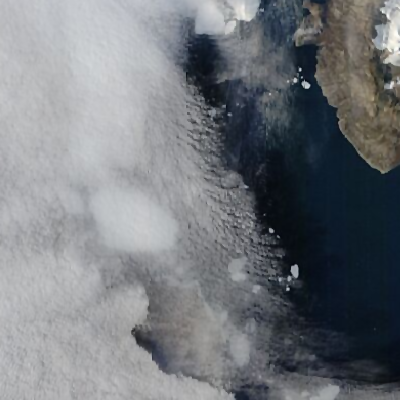

In [19]:
# 4. Diffusion
PMD = PeronaMalikDiffusion(0.1, 0.1, 5, "exponential")
truecolor_diffused = nonlinear_diffusion(truecolor, PMD)

# 5. Histogram adjustment
# 6. 